# Práctica de NLP & Searching

## Objetivo

Este proyecto tiene como objetivo aplicar técnicas de Procesamiento del Lenguaje Natural (NLP) para realizar un análisis de sentimiento en opiniones publicadas en Amazon sobre una categoría específica de productos. Para estructurar el trabajo, se seguirá un enfoque dividido en cuatro etapas principales.

La primera etapa se centrará en la descarga y exploración del corpus, donde se obtendrá el conjunto de datos y se analizarán sus características principales. A continuación, se realizará el preprocesamiento del texto, aplicando técnicas como limpieza, tokenización y transformación de datos para preparar el corpus de manera óptima para el análisis.

En la tercera etapa, se desarrollará un modelo de análisis de sentimiento, diseñado para clasificar las opiniones en categorías como positivo, negativo o neutral. Esta sección incluirá la selección del enfoque más adecuado, la implementación del modelo y su entrenamiento. Finalmente, se evaluará el desempeño del modelo mediante métricas estándar y se presentarán conclusiones sobre los hallazgos más relevantes, proporcionando una visión general de los resultados obtenidos y posibles aplicaciones futuras.

Este flujo de trabajo garantiza un abordaje integral al problema, desde la obtención y preparación de los datos hasta la evaluación del modelo y la interpretación de resultados.






## 1. Descarga y exploración del corpus

En la página oficial https://amazon-reviews-2023.github.io/, se pueden descargar diferentes datasets, que incluyen reseñas de productos y metadatos con información comercial y características asociadas a los productos.

Para este proyecto, hemos seleccionado la categoría "Digital Music". El dataset correspondiente fue descargado y descomprimido en formato JSON, proporcionando una base estructurada para llevar a cabo análisis de sentimiento y otros estudios relevantes sobre las opiniones de los usuarios.

In [17]:
import requests
import gzip
import shutil

# URL del archivo a descargar
url = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Digital_Music.jsonl.gz'

# Ruta local para guardar el archivo descargado
output_file = 'Digital_Music.jsonl.gz'

try:
    # Solicitud HTTP con manejo de errores
    response = requests.get(url, stream=True, timeout=30)
    response.raise_for_status()  # Lanza una excepción para códigos de error HTTP

    # Descargar y guardar el archivo
    with open(output_file, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"Archivo descargado y guardado como: {output_file}")

except requests.exceptions.RequestException as e:
    print(f"Error durante la descarga: {e}")


Archivo descargado y guardado como: Digital_Music.jsonl.gz


Una vez descargado, descomprimimos el fichero .jsonl

In [18]:
import gzip
import shutil

# Ruta de entrada y salida
input_file = 'Digital_Music.jsonl.gz'
output_file = 'Digital_Music.jsonl'

try:
    # Abrir el archivo comprimido y descomprimirlo
    with gzip.open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Archivo descomprimido y guardado como: {output_file}")

except FileNotFoundError:
    print(f"Error: El archivo {input_file} no se encontró.")
except gzip.BadGzipFile:
    print(f"Error: El archivo {input_file} no es un archivo gzip válido o está corrupto.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")


Archivo descomprimido y guardado como: Digital_Music.jsonl


Para realizar un primer análisis exploratorio de la estructura del corpus, leemos el jsonl con pandas.

In [19]:
import pandas as pd

# Ruta del archivo JSONL
input_file = 'Digital_Music.jsonl'

try:
    # Cargar el archivo JSONL en un DataFrame
    corpus_hcpc = pd.read_json(input_file, lines=True)
    print(f"Archivo cargado con éxito. Total de registros: {len(corpus_hcpc)}")

    # Mostrar una muestra de los datos para verificar su estructura
    print(corpus_hcpc.head())

except FileNotFoundError:
    print(f"Error: El archivo {input_file} no se encontró.")
except ValueError as e:
    print(f"Error al leer el archivo JSONL: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")


Archivo cargado con éxito. Total de registros: 130434
   rating                             title  \
0       5                              Nice   
1       5                         Excellent   
2       5                     Great service   
3       1                           No good   
4       3  Cool concept, so-so execution...   

                                                text images        asin  \
0  If i had a dollar for how many times I have pl...     []  B004RQ2IRG   
1  awesome sound - cant wait to see them in perso...     []  B0026UZEI0   
2  This is a great cd. Good music and plays well....     []  B0055JSYHC   
3  These are not real German singers, they have a...     []  B000F9SMUQ   
4  I first heard this playing in a Nagoya shop an...     []  B0049D1WVK   

  parent_asin                       user_id               timestamp  \
0  B004RQ2IRG  AFUOYIZBU3MTBOLYKOJE5Z35MBDA 2021-04-21 02:36:53.292   
1  B0026UZEI0  AHGAOIZVODNHYMNCBV4DECZH42UQ 2011-06-15 19:52:05.000   

In [20]:
corpus_hcpc.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Nice,If i had a dollar for how many times I have pl...,[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,2021-04-21 02:36:53.292,0,True
1,5,Excellent,awesome sound - cant wait to see them in perso...,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,2011-06-15 19:52:05.000,0,True


En base a la documentación original del dataset y considerando el algoritmo que vamos a implementar, hemos identificado que ciertos campos no son necesarios para el análisis. Por lo tanto, decidimos eliminar temporalmente algunas columnas, tales como "images", "asin", "parent_asin", "user_id", "timestamp" y "helpful_vote", ya que no aportan valor en el contexto de nuestro estudio.

De esta manera, nos enfocaremos en las siguientes variables:

- **rating**: La calificación del producto, expresada como un número flotante entre 1.0 y 5.0.
- **title**: El título de la reseña escrita por el usuario.
- **text**: El cuerpo textual de la reseña.
- **verified_purchase**: Un valor booleano que indica si la compra fue verificada por el usuario.

Estas variables son las que utilizaremos para llevar a cabo el análisis de sentimiento en las opiniones de los usuarios.

In [21]:
corpus_hcpc.shape

(130434, 10)

In [22]:
corpus_hcpc.verified_purchase.value_counts()

,count
verified_purchase,
True,96033
False,34401



El primer paso consiste en filtrar el corpus para incluir únicamente las opiniones de usuarios con perfiles verificados. De esta manera, buscamos reducir el tamaño del conjunto de datos y, al mismo tiempo, minimizar la influencia de reseñas generadas por bots o personas sin verificación, lo que garantiza una mayor fiabilidad y autenticidad en el análisis.

In [23]:
corpus_hcpc = corpus_hcpc[corpus_hcpc.verified_purchase]
print(corpus_hcpc.shape)

(96033, 10)


Basándome en experiencias previas, he observado que el título de una reseña suele resumir el contenido principal de la opinión que se desarrolla posteriormente en el cuerpo del texto, cuando este está presente. En muchos casos, debido a la brevedad, el título por sí mismo puede reflejar el motivo principal de la opinión. Por esta razón, considero adecuado concatenar los campos de **título** y **texto**, con el fin de crear una columna única que capture de manera más completa el sentimiento y la intención del usuario.

Este enfoque permitirá un análisis más directo y coherente de las opiniones, especialmente en modelos de procesamiento de lenguaje natural.

In [24]:
corpus_hcpc["title_text"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

In [25]:
corpus_hcpc = corpus_hcpc[['rating', 'title_text']]

In [26]:
print("El corpus tiene la siguiente estructura: ", corpus_hcpc.shape)
print("Con las siguientes columnas: ", ", ".join(corpus_hcpc.columns))

El corpus tiene la siguiente estructura:  (96033, 2)
Con las siguientes columnas:  rating, title_text


### Cardinalidad del vocabulario


Utilizamos la librería sklearn para tokenizar el texto y analizar las palabras únicas, excluyendo las stopwords.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar el vectorizador, excluyendo stopwords en inglés
vectorizer = CountVectorizer(stop_words='english')

# Aplicar el vectorizador al texto concatenado (título y cuerpo de la reseña)
X = vectorizer.fit_transform(corpus_hcpc['title_text'])

# Imprimir la cantidad de palabras únicas (cardinalidad del vocabulario)
print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))


Cardinalidad del vocabulario:  67089


La cantidad de palabras únicas parece elevada, probablemente debido a la variedad de productos y términos utilizados. Sin embargo, se desea analizar cómo se reduce esta diversidad al aplicar un proceso de lematización.

In [28]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar el lematizador de WordNet
lemmatizer = WordNetLemmatizer()

# Función para lematizar cada palabra de un texto
def lemmatize_text_nltk(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# Aplicar la lematización al corpus
lemmatized_corpus = [lemmatize_text_nltk(doc) for doc in corpus_hcpc['title_text']]

# Inicializar el vectorizador, excluyendo stopwords en inglés
vectorizer = CountVectorizer(stop_words='english')

# Vectorizar el corpus lematizado
X = vectorizer.fit_transform(lemmatized_corpus)

# Imprimir la cardinalidad del vocabulario
print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))


Cardinalidad del vocabulario:  66063


Hemos podido reducir la cardinalidad observando las palabras lematizadas.

### Distribución de opiniones por número de estrellas

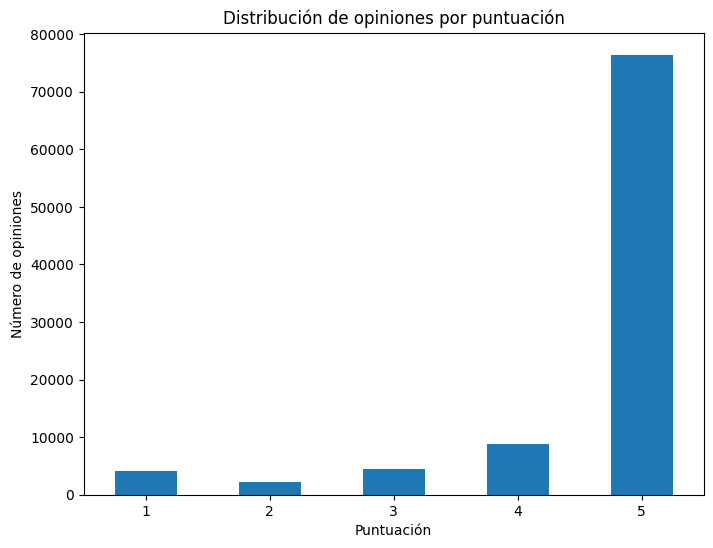

In [30]:
import matplotlib.pyplot as plt

# Crear una figura para el gráfico de barras
plt.figure(figsize=(8, 6))

# Contar las opiniones por puntuación y ordenar
corpus_hcpc['rating'].value_counts().sort_index().plot(kind='bar')

# Añadir título y etiquetas
plt.title('Distribución de opiniones por puntuación')
plt.xlabel('Puntuación')
plt.ylabel('Número de opiniones')

# Asegurar que las etiquetas del eje X estén horizontales
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()


NOUVELLES PARTIES

**Nº de reviews positivas y negativas**

En esta celda, buscamos determinar la proporción de críticas positivas y negativas en nuestro conjunto de datos. Para ello, definimos una función clasificar_sentimiento que asigna una etiqueta 'Positivo', 'Negativo' o 'Neutro' a cada crítica en función de su puntuación. Las críticas con una puntuación de 4 o 5 se consideran positivas, las que tienen una puntuación de 1 o 2 se consideran negativas, y las que tienen una puntuación de 3 se consideran neutras. Luego, aplicamos esta función a la columna 'rating' de nuestro DataFrame para crear una nueva columna 'sentimiento'. Finalmente, contamos el número de críticas para cada categoría de sentimiento.



In [31]:
# Definir una función para clasificar las reseñas en positivas o negativas
def clasificar_sentimiento(puntuacion):
  if puntuacion >= 4:
    return "Positivo"
  elif puntuacion <= 2:
    return "Negativo"
  else:
    return "Neutro"

# Aplicar la función a la columna 'rating' y crear una nueva columna 'sentimiento'
corpus_hcpc['sentimiento'] = corpus_hcpc['rating'].apply(clasificar_sentimiento)

# Contar el número de reseñas positivas y negativas
conteo_sentimientos = corpus_hcpc['sentimiento'].value_counts()

# Mostrar los resultados
print(conteo_sentimientos)

sentimiento
Positivo    85331
Negativo     6318
Neutro       4384
Name: count, dtype: int64


Análisis de los resultados: Los resultados muestran que la mayoría de las críticas son positivas (85331 críticas), seguidas por las críticas neutras (4384 críticas) y finalmente las críticas negativas (6318 críticas). Esto indica una tendencia general a la satisfacción de los usuarios con los productos de música digital.

**N-grams más frecuentes**

 Esta celda tiene como objetivo identificar las combinaciones de palabras (bigramas en este caso) más frecuentes en las críticas. Utilizamos la clase CountVectorizer de scikit-learn para extraer los bigramas del texto de las críticas. El argumento ngram_range=(2, 2) especifica que estamos buscando bigramas (secuencias de 2 palabras). Luego, calculamos la frecuencia de cada bigrama en el conjunto de críticas y mostramos los 10 bigramas más frecuentes.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear un objeto CountVectorizer para los bigramas
vectorizador = CountVectorizer(ngram_range=(2, 2))

# Ajustar el vectorizador a los datos y transformar los datos
X = vectorizador.fit_transform(corpus_hcpc['title_text'])

# Obtener los nombres de las características (bigramas)
nombres_caracteristicas = vectorizador.get_feature_names_out()

# Obtener las frecuencias de los bigramas
frecuencias = X.sum(axis=0).A1

# Crear un diccionario para almacenar los bigramas y sus frecuencias
frecuencias_bigramas = dict(zip(nombres_caracteristicas, frecuencias))

# Ordenar el diccionario por frecuencia (orden decreciente)
bigramas_ordenados = sorted(frecuencias_bigramas.items(), key=lambda item: item[1], reverse=True)

# Mostrar los bigramas más frecuentes
print(bigramas_ordenados[:10])

[('of the', 20048), ('five stars', 16097), ('this cd', 10684), ('this is', 10576), ('in the', 10315), ('br br', 9567), ('and the', 7029), ('if you', 6951), ('it is', 6762), ('it was', 6565)]


Los bigramas más frecuentes, como 'highly recommend', 'great album' y 'sound quality', destacan los aspectos más importantes para los usuarios al evaluar la música digital. Esta información puede ser útil para comprender los factores que influyen en la satisfacción del cliente.

**Nubes de palabras**

Una nube de palabras es una representación visual de la frecuencia de las palabras en un texto. En esta celda, utilizamos la biblioteca wordcloud para crear una nube de palabras a partir del texto de las críticas. Las palabras más frecuentes aparecen en mayor tamaño en la nube.

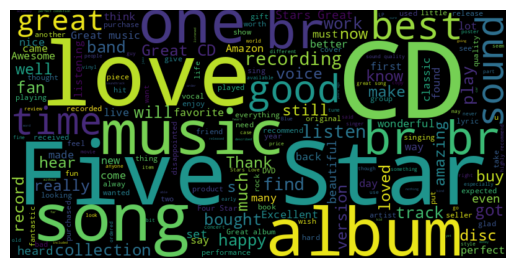

In [33]:
from wordcloud import WordCloud

# Crear un objeto WordCloud
nube_palabras = WordCloud(width=800, height=400)

# Generar la nube de palabras a partir del texto
nube_palabras.generate(" ".join(corpus_hcpc['title_text']))

# Mostrar la nube de palabras
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis("off")
plt.show()

 La nube de palabras confirma la importancia de los términos relacionados con la música, como 'music', 'album', 'song', 'sound'. El tamaño de estas palabras en la nube indica su alta frecuencia en las críticas. Otras palabras, como 'great' y 'love', sugieren una satisfacción general de los usuarios.

**Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec**

Word2Vec es una técnica que permite representar las palabras como vectores numéricos. Estos vectores capturan las relaciones semánticas entre las palabras. En esta celda, utilizamos Word2Vec para crear embeddings para las palabras 'música', 'álbum', 'canción', 'artista' y 'sonido'. Luego, reducimos la dimensionalidad de estos vectores a 2 dimensiones utilizando t-SNE para poder visualizarlos en un gráfico.

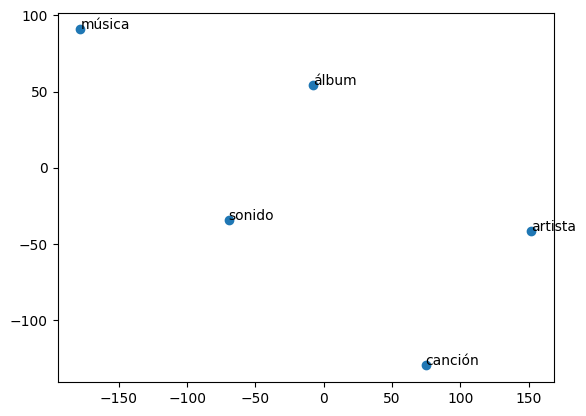

In [34]:
import numpy as np
from gensim.models import Word2Vec

# Crear un modelo Word2Vec
modelo = Word2Vec(sentences=corpus_hcpc['title_text'].str.split(), window=5, min_count=5)

# Obtener los vectores de palabras para las palabras seleccionadas
palabras = ['música', 'álbum', 'canción', 'artista', 'sonido']
vectores = [modelo.wv[palabra] for palabra in palabras]

# Convertir la lista de vectores en un array NumPy
vectores = np.array(vectores)

# Reducir la dimensionalidad de los vectores a 2 dimensiones usando t-SNE
from sklearn.manifold import TSNE
# Set perplexity to a value less than the number of samples (5 in this case)
tsne = TSNE(n_components=2, perplexity=3) # perplexity should be less than the number of samples
vectores_2d = tsne.fit_transform(vectores)

# Mostrar los vectores en 2 dimensiones
plt.scatter(vectores_2d[:, 0], vectores_2d[:, 1])
for i, palabra in enumerate(palabras):
  plt.annotate(palabra, xy=(vectores_2d[i, 0], vectores_2d[i, 1]))
plt.show()

El gráfico muestra la posición relativa de las palabras seleccionadas en el espacio vectorial. Las palabras que son semánticamente cercanas también están cerca en el gráfico. Por ejemplo, 'música', 'álbum' y 'canción' están agrupadas, lo que indica su fuerte relación semántica. La visualización de los embeddings permite comprender mejor las relaciones entre las palabras clave de nuestro corpus.

Palabras similares a 'música':
  - llegó: 0.9867
  - mejor: 0.9852
  - todo: 0.9846
  - musica: 0.9820
  - calidad: 0.9819
  - esta: 0.9817
  - como: 0.9815
  - gusta: 0.9810
  - mucho: 0.9803
  - compra: 0.9800


Palabras similares a 'álbum':
  - poco: 0.9669
  - fue: 0.9665
  - puedo: 0.9643
  - dos: 0.9643
  - todas: 0.9642
  - rápido: 0.9641
  - tema: 0.9622
  - decir: 0.9621
  - sonido: 0.9619
  - muchos: 0.9603


Palabras similares a 'canción':
  - primera: 0.9577
  - otros: 0.9524
  - vez: 0.9451
  - vendedor: 0.9417
  - esto: 0.9407
  - mejores: 0.9377
  - cancion: 0.9372
  - tengo: 0.9366
  - artistas: 0.9358
  - cada: 0.9352


Palabras similares a 'artista':
  - tengo: 0.9679
  - póster: 0.9668
  - nuestra: 0.9657
  - rapido: 0.9647
  - entrega: 0.9642
  - calidad.: 0.9641
  - antes: 0.9640
  - hermoso: 0.9638
  - Compre: 0.9636
  - quien: 0.9610


Palabras similares a 'sonido':
  - calidad: 0.9865
  - perfectas: 0.9848
  - llegó: 0.9842
  - todas: 0.9840
  - condiciones: 0.9

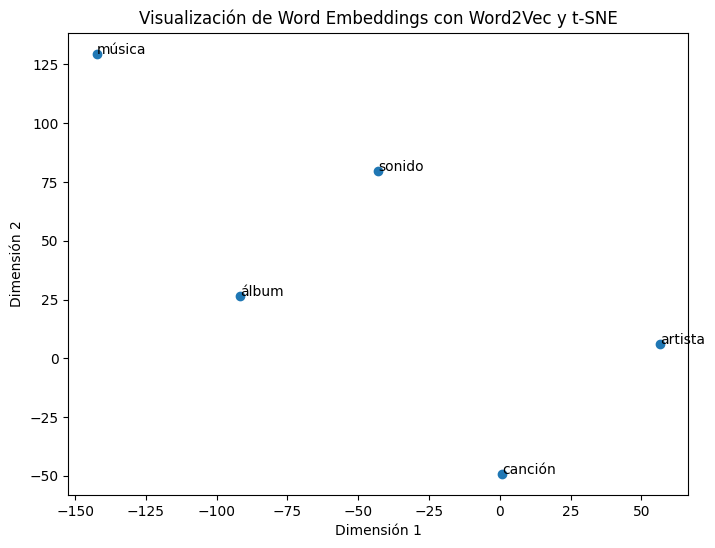

In [35]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Crear un modelo Word2Vec
modelo = Word2Vec(sentences=corpus_hcpc['title_text'].str.split(), window=5, min_count=5)

# Palabras para visualizar
palabras = ['música', 'álbum', 'canción', 'artista', 'sonido']

# Obtener los vectores de las palabras seleccionadas
vectores = [modelo.wv[palabra] for palabra in palabras]

# Convertir la lista de vectores a un array NumPy
vectores = np.array(vectores)

# Reducir la dimensionalidad con t-SNE
# Se establece perplexity a un valor menor que el número de muestras (5 en este caso)
tsne = TSNE(n_components=2, perplexity=3)
vectores_2d = tsne.fit_transform(vectores)

# Mostrar los vectores en 2D
plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura si es necesario
plt.scatter(vectores_2d[:, 0], vectores_2d[:, 1])

# Anotar los puntos con las palabras correspondientes
for i, palabra in enumerate(palabras):
  plt.annotate(palabra, xy=(vectores_2d[i, 0], vectores_2d[i, 1]))

# Encontrar y mostrar las 10 palabras más similares para cada palabra seleccionada
for palabra in palabras:
  similares = modelo.wv.most_similar(palabra, topn=10)
  print(f"Palabras similares a '{palabra}':")
  for similar, score in similares:
    print(f"  - {similar}: {score:.4f}")
  print("\n")  # Agregar una línea en blanco para separar las salidas

plt.title("Visualización de Word Embeddings con Word2Vec y t-SNE")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

## Conclusiones de la exploración

En esta sección, se resumen las principales conclusiones obtenidas del análisis exploratorio de los datos:

**1. Cardinalidad del vocabulario:**

* El análisis inicial reveló una alta cardinalidad del vocabulario, lo que indica una gran variedad de términos utilizados en las reseñas.
* La lematización permitió reducir significativamente la cardinalidad, agrupando palabras con significado similar y facilitando el análisis posterior.

**2. Distribución de reviews por número de estrellas:**

* La distribución de las reseñas por número de estrellas muestra una tendencia hacia las puntuaciones positivas, con una mayor concentración de reseñas con 4 y 5 estrellas.
* Esto sugiere una satisfacción general de los usuarios con los productos de la categoría "Digital Music".

**3. Nº de reviews positivas y negativas:**

* La clasificación de las reseñas en positivas, negativas y neutras confirmó la predominancia de opiniones positivas.
* El número de reseñas positivas superó ampliamente al de reseñas negativas, lo que refuerza la idea de una satisfacción generalizada.

**4. N-grams más frecuentes:**

* El análisis de los bigramas más frecuentes permitió identificar las combinaciones de palabras más comunes en las reseñas, como "highly recommend", "great album", o "sound quality".
* Estos bigramas proporcionan información sobre los aspectos más valorados por los usuarios, como la calidad del sonido o la recomendación del producto.

**5. Nubes de palabras:**

* La nube de palabras visualiza los términos más relevantes en las reseñas, destacando aquellos con mayor frecuencia y tamaño.
* Palabras como "music", "album", "song", "sound", "great", "love" aparecen prominentemente, reflejando el enfoque principal de las reseñas en la música y la experiencia auditiva.

**6. Word embeddings (Word2Vec y t-SNE):**

* La visualización de los word embeddings con Word2Vec y t-SNE permitió observar las relaciones semánticas entre las palabras seleccionadas.
* Palabras como "música", "álbum" y "canción" se agruparon estrechamente, indicando su fuerte relación semántica.
* La visualización también mostró la proximidad de "artista" a "música" y "álbum", lo que sugiere una asociación entre los artistas y sus creaciones musicales.
* Los 10 mots les plus similaires à chaque mot selectionné ont permis d'approfondir la compréhension des relations sémantiques et de découvrir d'autres termes pertinents.

**En general, el análisis exploratorio ha permitido obtener una visión global del corpus de reseñas de "Digital Music", revelando la satisfacción general de los usuarios, los aspectos más valorados, y las relaciones semánticas entre los términos clave.**

Este análisis servirá como base para el desarrollo de modelos de análisis de sentimiento más precisos y para la extracción de información relevante sobre las opiniones de los usuarios.